In [1]:
#!pip install -U scikit-fuzzy
#!pip install skfuzzy
#!pip install -U shap

In [2]:
import time
import numpy as np
import pandas as pd
import random
import shap
import pickle

from sklearn.cluster import KMeans

import skfuzzy as fuzz
from scipy import linalg as la
from sklearn.metrics import accuracy_score
from sklearn.base import MultiOutputMixin, BaseEstimator

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [4]:
datasets = ['ecoli', 'glass', 'heart-statlog', 'iris', 'liver-disorders', 'pima', 'vehicle', 
            'wine-quality-red', 'yeast', 'vertebra-column-2c', 'saheart', 'new-thyroid',
            'echocardiogram', 'appendicitis', 'hayes-roth']

In [1]:
# Local imports
from FuzzyCMeansWrapper import FuzzyCMeans
from KMeansfunctions import f_importance
from miscellaneous import featuresorting
from KMeansfunctions import kmeans_performance
from FuzzyCMeansWrapper import fcmperformance
from miscellaneous import tablecreator

In [6]:
import os
def directorycreation(): 
    # Creating the Results sub-folder if it doesn't exist yet
    script_dir = os.getcwd()
    directories = ['plots/', "importance_scores/", "error_scores/"]
    for i in directories:
        results_dir = os.path.join(script_dir, i)

        if not os.path.isdir(results_dir):
            os.makedirs(results_dir)

Using 1599 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1599 [00:00<?, ?it/s]

Using 1599 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1599 [00:00<?, ?it/s]

KeyError: 'PFBI FuzzyCMeans'

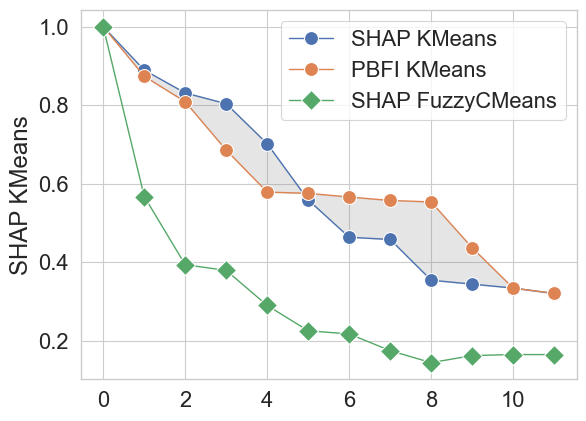

In [7]:
shap_max_size = 99999
from sklearn.cluster import KMeans
import numpy as np

for dataset in datasets:
    #Creating all sub-directories for saving of files
    directorycreation()

    # loading the current dataset
    df = pd.read_csv('./datasets/'+dataset+'.csv')
    n_centers = len(np.unique(df.values[:,-1]))
    df = df.drop(df.columns[-1], axis='columns')

    #Kmeans true clusters calculated and each point assigned to a cluster
    kmeans = KMeans(init="random", n_clusters=n_centers, n_init=10, max_iter=1000, random_state=0)
    kmeans.fit(df.values)
    y_true_kmeans = kmeans.predict(df.values)

    #FuzzyCMeans clusters calculated and each point assigned to a cluster
    fcm = FuzzyCMeans(n_centers, seed=0).fit(df.values)
    y_true_fcm = np.argmax(fcm.predict(df.values), axis=1)

    # sample shap if nr. of data points above max shap size (used for testing purposes)
    if df.shape[0] > shap_max_size:
        shapdf = shap.sample(df, shap_max_size)
    else:
        shapdf = df

    # average shap values FCM
    fcm_ex = shap.KernelExplainer(fcm.predict, df)
    shap_values = fcm_ex.shap_values(shapdf)
    ave_shap_values_fcm = np.zeros(shap_values[0].shape[1])
    for shap_i in shap_values:
        ave_shap_values_fcm += np.mean(np.absolute(shap_i), axis=0)

    # average shap values KMeans
    fcm_ex = shap.KernelExplainer(kmeans.predict, df)
    shap_values = fcm_ex.shap_values(shapdf)
    ave_shap_values_kmeans = np.zeros(shap_values.shape[1])
    ave_shap_values_kmeans += np.mean(np.absolute(shap_values), axis=0)

    # Dataframe with importance scores, provides a df with the feature importance for each feature under the 4 models
    pbfi_df = tablecreator(fcm.f_importance(df.values),ave_shap_values_fcm,f_importance(kmeans.cluster_centers_, df.values), ave_shap_values_kmeans)
    pbfi_df.insert(0,"features",df.columns )
    
    pbfi_df.to_excel(f"./importance_scores/importance_scores_{dataset}.xlsx")

    # Sorting features in order of importance and returning labels
    FuzzyCMeans_labels, KMeans_labels, Shap_labels_fcm, Shap_labels_kmeans = featuresorting(pbfi_df)

    #### computing the perturbation errors for KMeans
    # PFBI KMeans
    errors_kmeans = kmeans_performance(df, KMeans_labels, kmeans, y_true_kmeans)
    # SHAP KMeans
    errors_shap_kmeans = kmeans_performance(df, Shap_labels_kmeans, kmeans, y_true_kmeans)
    
    ### computing the perturbation errors for Fuzzy C Means
    # PFBI Fuzzy C Means
    errors_fuzzycmeans = fcmperformance(df, FuzzyCMeans_labels, fcm, y_true_fcm)
    # SHAP Fuzzy C Means
    errors_shap_fuzzycmeans = fcmperformance(df, Shap_labels_fcm, fcm, y_true_fcm)

    #Creating df with accuracy
    error_df = tablecreator(errors_fuzzycmeans, errors_shap_fuzzycmeans, errors_kmeans, errors_shap_kmeans )
    
    error_df.to_excel(f"./error_scores/error_scores_{dataset}.xlsx")


In [1]:
from plotting import resultplot

### PLOTTING
# datasets variable recreated for testing purposes for testing smaller nr. of datasets
datasets = ['ecoli', 'glass', 'heart-statlog', 'iris', 'liver-disorders', 'pima', 'vehicle', 
            'wine-quality-red', 'yeast', 'vertebra-column-2c', 'saheart', 'new-thyroid',
            'echocardiogram', 'appendicitis', 'hayes-roth']

resultplot(datasets, which="both") # which controls wether to plot both, only kmeans, or only Fuzzycmeans in the same graph

Completed figure 1 out of 15 total
Completed figure 2 out of 15 total
Completed figure 3 out of 15 total
Completed figure 4 out of 15 total
Completed figure 5 out of 15 total
Completed figure 6 out of 15 total
Completed figure 7 out of 15 total
Completed figure 8 out of 15 total
Completed figure 9 out of 15 total
Completed figure 10 out of 15 total
Completed figure 11 out of 15 total
Completed figure 12 out of 15 total
Completed figure 13 out of 15 total
Completed figure 14 out of 15 total
Completed figure 15 out of 15 total


In [72]:
#Creation of overview table for importance scores
import pandas as pd 

datasets = ['vehicle', 'heart-statlog','echocardiogram', 'wine-quality-red','glass','saheart','pima','yeast','appendicitis','ecoli',
'liver-disorders','vertebra-column-2c','new-thyroid','hayes-roth','iris']
maindf = pd.DataFrame()

for dataset in datasets:
    # loading the performance scores dataset
    df = pd.read_excel('./importance_scores/importance_scores_'+dataset+'.xlsx',header=None)
    df = df.iloc[:,1:]  #removes the index column
    df = df.transpose()
    df = df.iloc[1:,:]  #removes the index column
    df.insert(0,"Dataset", [dataset,None,None,None])
    maindf = pd.concat([maindf,df])

maindf.columns = ["Dataset","Model scoring method", "F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "F9", "F10", "F11", "F12", "F13", "F14", "F15", "F16", "F17", "F18"]
maindf.to_csv(f"./importance_scores/importance_scores_combined.csv")


